In [2]:
import torch
from torch import nn
import torchvision
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os

In [571]:
# Как было сказано ранее, GAN обучается воспроизводить реальные данные. Поэтому Вам предлагается обучить генератор создавать точки, которые будут лежать на графике функции
# 𝑦 = 𝑠𝑖𝑛(x)/x − x/10
# При выполнении данного задания структура GAN остается той же, но Вам нужно:
# ● Сгенерировать настоящие данные
# ● Изменить архитектуру дискриминатора и генератора
# ● Без графиков домашку не принимаю

In [572]:
# plot function
# x = np.linspace(-5, 5, 50)
# y = np.sin(x) / x - x / 10
# plt.figure(figsize=(8, 5))
# plt.xlabel('x')
# plt.ylabel('y')
# plt.title('Function sin(x) / x - x / 10 vizualization')
# plt.plot(x, y, c='blue', linestyle='dashed');


In [3]:
def plot_function(x, y, save=False, save_name=None, type_plot='plot', fig_s=(8, 5)):
    plt.figure(figsize=fig_s)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Function sin(x) / x - x / 10 vizualization')
    if type_plot == 'plot':
      plt.plot(x, y, c='blue', linestyle='dashed');
    else:
      plt.scatter(x, y, c='red')     
    if save:
        return plt.savefig(save_name)
            

In [574]:
is_cuda = torch.cuda.is_available()
device = torch.device('cuda') if is_cuda else torch.device('cpu')
device

device(type='cpu')

In [4]:
# genereate data

#real
real_x = np.linspace(-10, 10, 5000)
real_y = torch.from_numpy(np.sin(real_x)/real_x - real_x/10)
real_x = torch.from_numpy(np.linspace(-10, 10, 5000))

In [576]:
len(real_x), len(real_y)

(5000, 5000)

In [577]:
type(real_x), type(real_y)

(torch.Tensor, torch.Tensor)

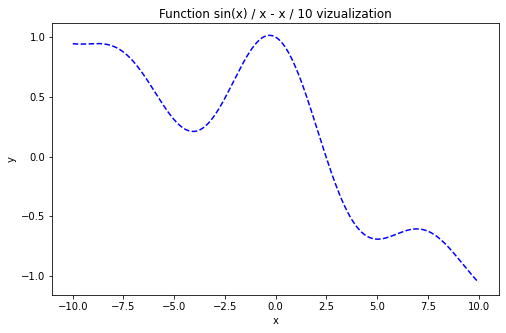

In [578]:
plot_function(real_x, real_y)

In [579]:
# preprocess data
class FunctionData(nn.Module):
    def __init__(self, x, y):
        super().__init__()
        self.x = x
        self.y = y
        
        
    def __len__(self):
        return len(self.x)
    
    
    def __getitem__(self, idx):      
        return self.x[idx], self.y[idx]

In [580]:
real = FunctionData(real_x, real_y)

In [581]:
BATCH_SIZE = 50
train = torch.utils.data.DataLoader(real, batch_size=BATCH_SIZE)                                  

In [582]:
class Gen(nn.Module):
    def __init__(self):
        super().__init__()
        self.activation = nn.ModuleDict([
            ['L-Relu', nn.LeakyReLU()],
            ['Relu', nn.ReLU()] ,
            ['Tanh', nn.Tanh()]
        ])
        
        def block(in_features, out_features, normalize=True, activation='Tanh'):
            layers = [nn.Linear(in_features, out_features)]
        
            if normalize:
                layers.append(nn.BatchNorm1d(out_features))
            layers.append(self.activation[activation])
        
            return layers
    
        self.model = nn.Sequential(
        *block(latent_dim, 50, normalize=False),
        *block(50, 100),
        *block(100, 200),
        nn.Linear(200, 1)
        )              
         
    def forward(self, x):
        x = self.model(x)
        return(x)

In [583]:
class Dis(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.model = nn.Sequential(
        nn.Linear(1, 200),
        nn.Tanh(),
        nn.Linear(200, 100),
        nn.Tanh(),
        nn.Linear(100, 1),
        nn.Sigmoid()              
        )
        
    def forward(self, x):
        return self.model(x)
        

In [608]:
# Parameters
EPOCHS_NUM = 850
latent_dim = 1

In [609]:
gen = Gen()
dis = Dis()

In [610]:
# set optimizers and loss
lr = 0.0005 # шаг обучения

b1 = 0.5 # гиперпараметр для оптимайзера Adam
b2 = 0.999 # гиперпараметр для оптимайзера Adam
optimizer_g = torch.optim.Adam(gen.parameters(), lr=lr, betas=(b1, b2))
optimizer_d = torch.optim.Adam(dis.parameters(), lr=lr, betas=(b1, b2))
loss = torch.nn.BCELoss()

In [611]:
len(train)

100

In [612]:
# Train
for i in range(EPOCHS_NUM):
    for X, Y in train:
        # Train generator
       
        # generate fake data
        fake_x = np.random.uniform(-10, 10, BATCH_SIZE).astype('float32')
        #fake_label = torch.from_numpy(np.sin(fake_x)/fake_x - fake_x/10).unsqueeze(1)
        fake_x = torch.from_numpy(fake_x).unsqueeze(1)
        fake_label = torch.zeros(fake_x.shape)
        valid_label = torch.ones(fake_x.shape)
        
        optimizer_g.zero_grad()
        
        fake_y = gen(fake_x)
        # fake y in discriminator
        validity = dis(fake_y)
        
        gen_loss = loss(validity.double(), valid_label.double())
        gen_loss.backward()
        optimizer_g.step()
        
        # Train discriminator
        
        optimizer_d.zero_grad()
        
        real_preds = dis(X.reshape(BATCH_SIZE, 1).float())
        real_loss = loss(real_preds.float(), valid_label.float())
        
        fake_preds = dis(fake_x)
        fake_loss = loss(fake_preds, fake_label)
        
        dis_loss = (real_loss + fake_loss) / 2
        dis_loss.backward()
        optimizer_d.step()
    if i != 0 and i % 50 == 0:
      print(f'Epoch{i} generator loss {gen_loss}')
      print(f'Epoch{i} discriminator loss {dis_loss}')     
            
        
        
        

Epoch50 generator loss 0.7021475193701653
Epoch50 discriminator loss 0.6843079328536987
Epoch100 generator loss 0.691284236251906
Epoch100 discriminator loss 0.6926966309547424
Epoch150 generator loss 0.691192338295663
Epoch150 discriminator loss 0.6931033134460449
Epoch200 generator loss 0.690878078617915
Epoch200 discriminator loss 0.6931433081626892
Epoch250 generator loss 0.6555806927654557
Epoch250 discriminator loss 0.6931470632553101
Epoch300 generator loss 0.5775830428322464
Epoch300 discriminator loss 0.6931471824645996
Epoch350 generator loss 0.7009262550868641
Epoch350 discriminator loss 0.6931471824645996
Epoch400 generator loss 0.693149929530135
Epoch400 discriminator loss 0.6931471824645996
Epoch450 generator loss 0.6931490521475442
Epoch450 discriminator loss 0.6931471228599548
Epoch500 generator loss 0.6931488494913917
Epoch500 discriminator loss 0.6931471824645996
Epoch550 generator loss 0.6931488494913917
Epoch550 discriminator loss 0.6931471824645996
Epoch600 generat

In [613]:
test = np.linspace(-10, 10, 500).reshape(500, 1)
np.random.shuffle(test)
test = torch.from_numpy(test).float()
predictions = gen(test)

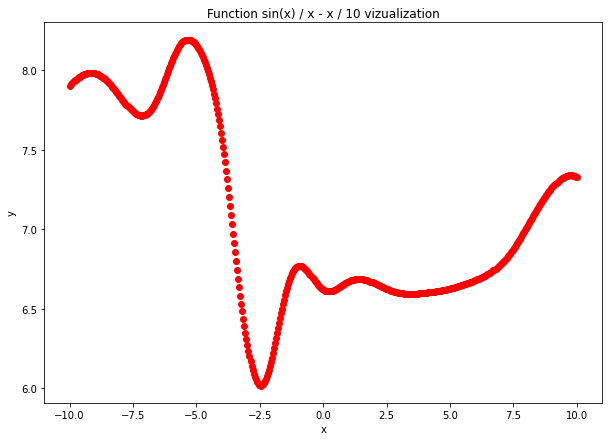

In [614]:
# 1) Интервал по y каждый раз разный, а в реальных данных от -1 до 1. Это нормально?
# ошибка особо не меняется, но меньше чем на 800 эпох не получается ничего похожего, а больше - переобучение
# пробовала разный lr, но толку мало. Ошибку не могу найти, где она?
# 2) При равных параметрах и количество эпох получаются очень разные результаты, почему?
plot_function(test.detach().numpy(), predictions.detach().numpy(), type_plot="scatter", fig_s=(10, 7), save=True, save_name='825 epochs.png' )

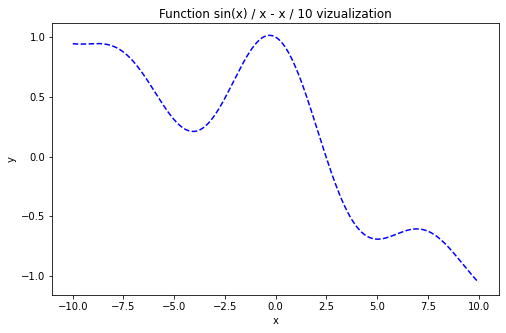

In [5]:
# real data
plot_function(real_x, real_y)

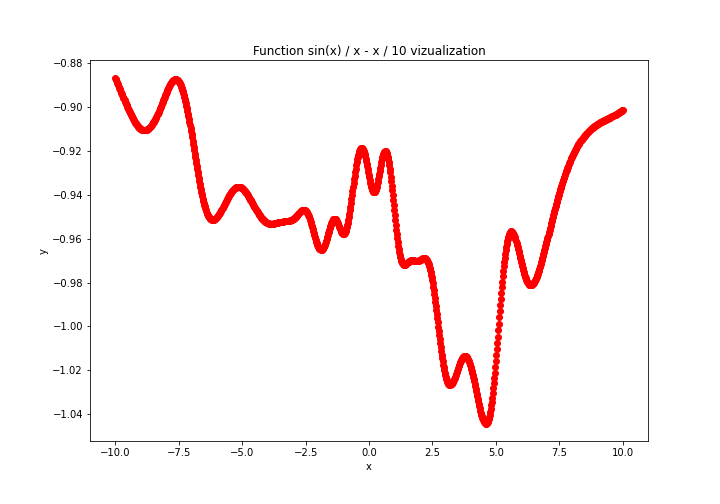

In [22]:
# 840 эпох: интервал уже похож на правду, но не особо похоже на реальные данные
from IPython.display import Image
Image("g_840_epochs.png")

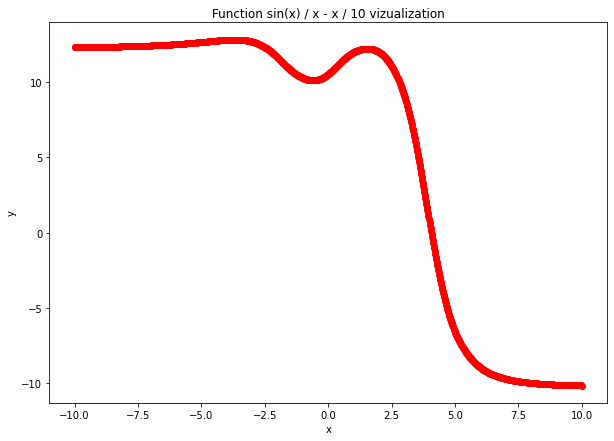

In [23]:
# lr=0.0002 Эпох примерно 840. Больше похоже на правду, но интервал фу-фу-фу
# и если перезапустить обучение будет другой результат
Image("Unknown-7.png")